# The Introduction
> Who: Shorter, a Data Science bootcamp student in the Leavitt Cohort at Code Up

> What: A presentation and project detailing work done to investigate customer churn from the Telco dataset. 

## Objective 
> Analyze dataset featuring customer details of a telecummunications company  

> Utilize statistical models to aid in analysis and prodcution of actionable insights  

> Construct report summarizing findings


## Business Goals
> Find drivers for customer churn at Telco. Why are customers churning?</br>

> Construct a ML classification model that accurately predicts customer churn.</br>

## Executive Summary
> Month-to-month customers seem more sensitive to higher prices than other groups

> Customers with less than 12 months more sensitive to higher prices

> Fiber customers pay higher than average, but those that churn pay *less* than those that do not

> Newer fiber customers at highest risk for churn

# The Work
> A condensed set of information that follows work done in pursuit of project objectives
* Full version available in `working_notebook.ipynb` in this same repository

## Imports 
> Python code accomplishing the necessary module and function imports to run the notebook 

In [40]:
# imports from major python libraries for dataframe and visualization creation/manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modules containing bespoke functions to aid in data preparation and modeling
import acquire
import prepare
import model

# modules for support functions
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# the machine learning models
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

## Acquire
> Python code handling the importation of data from the Code Up database

In [41]:
#acquire data and do rudimentary exploration
df = acquire.get_telco_data()
df.head()

,internet_service_type_id,payment_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type
0,1,2,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,Mailed check,DSL
1,1,2,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,Mailed check,DSL
2,2,1,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Electronic check,Fiber optic
3,2,1,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Electronic check,Fiber optic
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Mailed check,Fiber optic


In [42]:
# working with a deep copy of the required data
working = df.copy(deep=True)

### Takeaways
* Fair amount of categories need to be encoded
* Drop `id` columns

# Prepare
> Python code implementing Takeaways from Acuire section and preparing the data for Exploration and Modeling

In [43]:
# view dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   internet_service_type_id  7043 non-null   int64  
 1   payment_type_id           7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [44]:
df.describe()
# id columns serve no purpose. *drop
# tenure appears to be in months, monthly charges in dollars
# where is total_charges? checked --> type == object. *must convert

,internet_service_type_id,payment_type_id,contract_type_id,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.872923,2.315633,1.690473,0.162147,32.371149,64.761692
std,0.737796,1.148907,0.833755,0.368612,24.559481,30.090047
min,1.000000,1.000000,1.000000,0.000000,0.000000,18.250000
25%,1.000000,1.000000,1.000000,0.000000,9.000000,35.500000
50%,2.000000,2.000000,1.000000,0.000000,29.000000,70.350000
75%,2.000000,3.000000,2.000000,0.000000,55.000000,89.850000
max,3.000000,4.000000,3.000000,1.000000,72.000000,118.750000


In [45]:
# convert series dtype to numeric after editing, and describe --> *make perm in prepare module
pd.to_numeric(df.total_charges.str.strip()).describe() 

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: total_charges, dtype: float64

In [46]:
# dataframe containing categorical columns
cat_col = df.select_dtypes(exclude='number').drop(columns=['customer_id', 'total_charges'])

#iterate through categorical columns
for col in cat_col:
   print(df[col].value_counts())
   print(df[col].value_counts(normalize=True))
   print(('------\n'))


Male      3555
Female    3488
Name: gender, dtype: int64
Male      0.504756
Female    0.495244
Name: gender, dtype: float64
------

No     3641
Yes    3402
Name: partner, dtype: int64
No     0.516967
Yes    0.483033
Name: partner, dtype: float64
------

No     4933
Yes    2110
Name: dependents, dtype: int64
No     0.700412
Yes    0.299588
Name: dependents, dtype: float64
------

Yes    6361
No      682
Name: phone_service, dtype: int64
Yes    0.903166
No     0.096834
Name: phone_service, dtype: float64
------

No                  3390
Yes                 2971
No phone service     682
Name: multiple_lines, dtype: int64
No                  0.481329
Yes                 0.421837
No phone service    0.096834
Name: multiple_lines, dtype: float64
------

No                     3498
Yes                    2019
No internet service    1526
Name: online_security, dtype: int64
No                     0.496663
Yes                    0.286668
No internet service    0.216669
Name: online_security, dty

In [47]:
# reassign with prep_telco output to prepare for data split
working = prepare.prep_telco(working)
working

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,online_backup_No internet service,online_backup_Yes,device_protection_No internet service,device_protection_Yes,tech_support_No internet service,tech_support_Yes,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,...,0,1,0,0,0,1,0,1,0,0
1,Male,0,No,No,9,Yes,Yes,No,No,No,...,0,0,0,0,0,0,0,0,0,1
2,Male,0,No,No,4,Yes,No,No,No,Yes,...,0,0,0,1,0,0,0,0,0,0
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,...,0,1,0,1,0,0,0,1,0,1
4,Female,1,Yes,No,3,Yes,No,No,No,No,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Female,0,No,No,13,Yes,No,Yes,No,No,...,0,0,0,0,0,1,0,0,0,0
7039,Male,0,Yes,No,22,Yes,Yes,No,No,No,...,0,0,0,0,0,0,0,0,0,1
7040,Male,0,No,No,2,Yes,No,No,Yes,No,...,0,1,0,0,0,0,0,0,0,0
7041,Male,0,Yes,Yes,67,Yes,No,Yes,No,Yes,...,0,0,0,1,0,1,0,0,0,1


In [48]:
# assign total_charges value to zero for customers with zero tenure ---> these are new customers
working.total_charges.fillna(0.00, inplace=True)

In [49]:
# split the data with target *churn*
train, validate, test = prepare.split_data(working, 'churn')

Prepared df: (7043, 47)

Train: (4225, 47)
Validate: (1409, 47)
Test: (1409, 47)


### Takeaways
> Safe to get rid of columns used for SQL join.   

> Customer id has no bearing on analysis  

> Appears to have no missing values  

> Numerous categorical columns need to be encoded  

> `total_charges` not useful datatype

> Broad View Stats as percentage of customer population
* Balanced (~50/50): gender, partner, multiple lines, streaming_tv, streaming_movies
 
* Imbalanced : multiple_lines, online_security, online_backup, dependents, device_protection, tech_support, paperless_billing, churn, contract_type, electronic_check, contract_type, internet_service_type

### Actions --> Executed in `prepare.py` module
> Encode Categorical Columns:

> `'gender', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'online_security','online_backup', 'device_protection', 'tech_support', 'streaming_tv','streaming_movies', 'paperless_billing', 'churn', 'contract_type', 'payment_type', 'internet_service_type'`

Drop: 
> `internet_service_type_id`, `payment_type_id`, `contract_type_id`, `customer_id` 
 
> `categorical columns after one-hot or binary encoding` --> save until after Explore

Convert: 
>`total_charges` -> `object` to `float64`</br> 

# Explore
> Python code performatin exloratory examination of data prior to modeling

### Univariate Takeaways
Analytical exploration of single variable information

> Confirmed balanced split mentioned in **Prepare** for most columns

> Takeaways from *imbalanced* features:
* Dependents: Most customers without dependents  
* Tenure: Tenure is bookended by large numbers at the extremes
* Phone Service: Most customers have phone service
* Multiple Lines: Those with phone service are slightly more likely to NOT have multiple lines
* Online Security : Most do not have online security
* Online Backup: Most do not have online backup
* Device Protection: Most do not have device protection
* Tech Support: Most do not have tech support
* Paperless Billing: Most customers opt for paperless billing
* Contract Type: Month-to_month is the preferred contract type
* Payment Type: Electronic Check most prefered payment type
* Internet Service Type: Fiber Optic most popular internet service type


### Bivariate Exploration
Python Code and Visuals exploring interaction of the target `churn` with other variables


In [50]:
# create dictionary to hold titles for takeaways from second set of bivariate visuals
bivariate_b_titles = {'partner': '\"No\" partner rate increased among churned customers',\
                    'tenure': 'Churn heavily skewed towards lower tenured customers',\
                    'contract_type': '~80% of churned on month-to-month contracts',\
                    'internet_service_type': 'Fiber customers make up well over 60% of churn customers'}

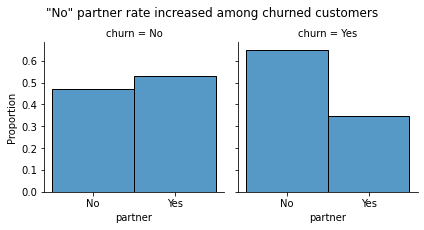

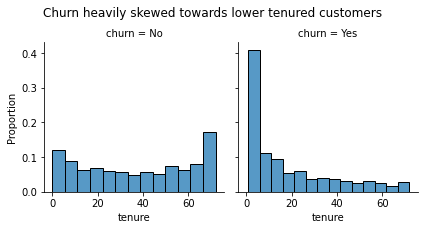

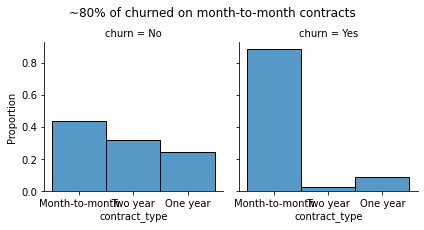

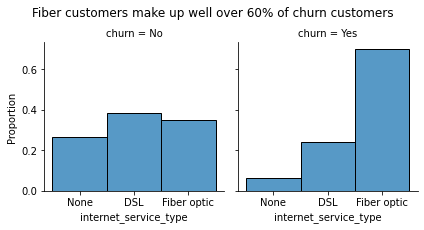

In [51]:
# create different visuals for columns identified above for further exploration or improved clarity
bivariate_b = ['partner', 'tenure', 'contract_type', 'internet_service_type']
for col in bivariate_b:
    viz_biv = sns.FacetGrid(data=train, col='churn')
    viz_biv.map_dataframe(sns.histplot, x=col, stat="proportion", multiple='dodge')
    viz_biv.fig.suptitle(bivariate_b_titles[col], y=1.05)

Text(0.5, 0.98, 'More balanced churn porportions than other customer groups')

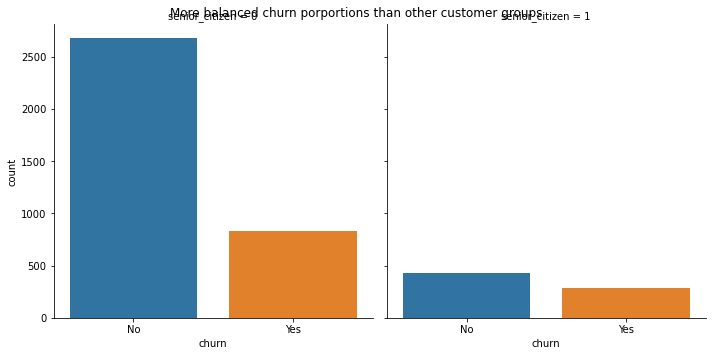

In [52]:
#need graph to see if 
sns.catplot(data=train, x='churn' , col='senior_citizen', kind='count') 
plt.suptitle('More balanced churn porportions than other customer groups')


#### Takeaways
* Gender: 'Roughly equal gender representation in churn vs no_churn
* **Senior Citizen: Greater proportion of churned than population**
    * More balanced churn porportions than other customer groups</br></br>
* **Partner: Single customers make up greater proportion of churned**
* Dependents: Most customers without sependents
* **Tenure: Longer tenure seems associated with less churn**
    * Churn heavily skewed towards lower tenured customers</br></br>
* Phone Service: Seems to have no change in churn vs no churn
* Multiple Lines: Minimal change between churn/no_churn
* Online Security: High level of churned had no online security
* Online Backup: High level of churned had no online backup
* Device Protection: High level of churned had no device_protection
* Tech Support: High level of churned had no online security
* Streaming TV: Slightly higher percentage of churned had no streaming tv. A reversal from no churn
* Streaming Movies: Roughly equal proportions of streaming optinos churned/no churn
* Paperless Billing: Opting for paperless billing makes up greater portion of churned
* **Monthly Charges: Churned customers have higher than average bills**
* Total Charges: Nothing interesting
* Churn: ----------
* **Contract Type: Month-to_month make up much greater proportion of churned**
    * ~80% of churned on month-to-month contracts</br></br>
    
* Payment Type: Electronic check more highly represented among churned vs no churn
* **Internet Service Type: Fiber Optic overrepresented among the churned**
    * Fiber customers make up well over 60% of churn customers

## Multivariate
Python code and Visualizations exploring questions that arose from Univariate and Bivariate phases

### Questions
* `churn` vs `contract_type` and `monthly_charges`
* `churn` vs `tenure` and `monthly_charges`
* `churn` vs `internet_service_type` and `monthly_charges`
* `churn` vs `tenure` and `internet_service_type`

##### Are there differences in the monthly charges and contract types that affect churn together?
* `churn` vs `contract_type` and `monthly_charges`
* Takeaway: Month-to-month customers seem more sensitive to higher prices than other groups

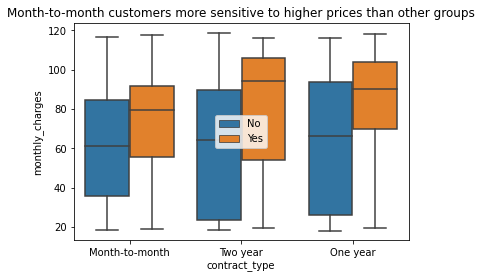

In [53]:
sns.boxplot(data=train, x='contract_type', y='monthly_charges', hue='churn')
plt.title('Month-to-month customers more sensitive to higher prices than other groups')
plt.legend()
plt.show()

#### Are customers less senstive to price over time?
* `churn` vs `tenure` and `monthly_charges`

In [54]:
tenure_bins = [0,12,24,36,48,60]
train['tenure_group']=pd.cut(train['tenure'],tenure_bins, include_lowest=True)

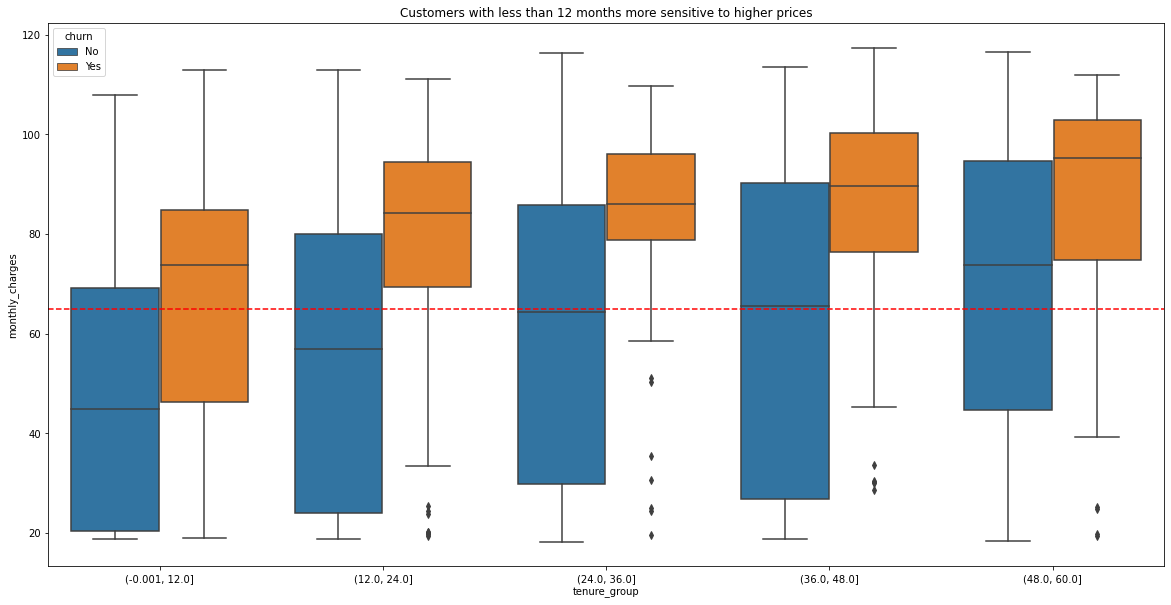

In [55]:
plt.figure(figsize=(20,10))
sns.boxplot(data=train, x='tenure_group', y='monthly_charges', hue='churn')
plt.axhline(y=train.monthly_charges.mean(), color='red', linestyle='dashed')
plt.title('Customers with less than 12 months more sensitive to higher prices')
plt.show()

* Are fiber customers charged more?
    * `churn` vs `internet_service_type` and `monthly_charges`

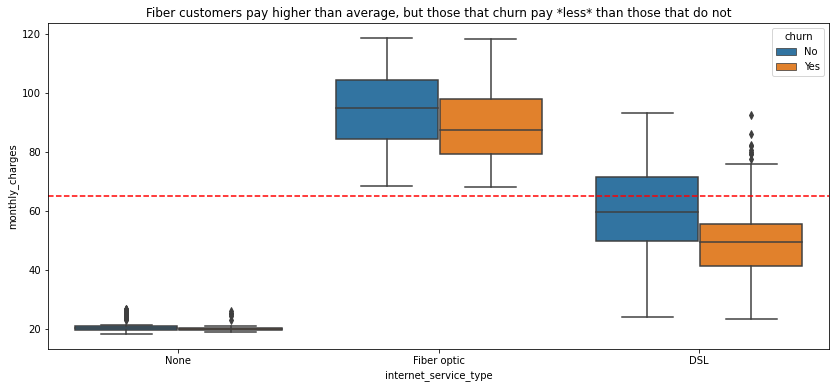

In [56]:
plt.figure(figsize=(14,6))
sns.boxplot(data=train, x='internet_service_type', y='monthly_charges', hue='churn')
plt.axhline(y=train.monthly_charges.mean(), color='red', linestyle='dashed')
plt.title('Fiber customers pay higher than average, but those that churn pay *less* than those that do not')
plt.show()

* Is there a problem with certain services over time?
    * `churn` vs `tenure` and `internet_service_type`


<Figure size 1440x432 with 0 Axes>

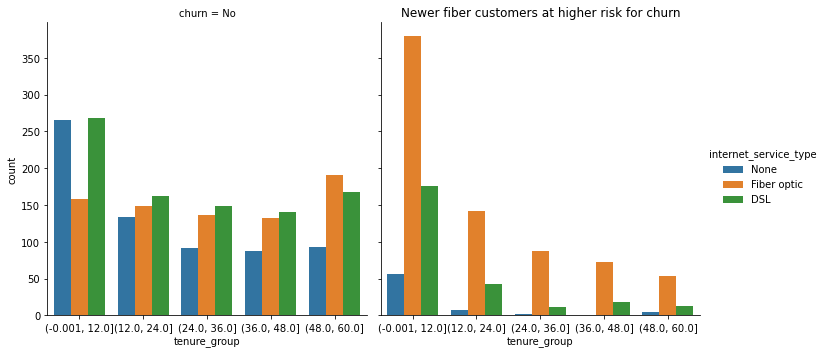

In [57]:
plt.figure(figsize=(20,6))
sns.catplot(data=train, x='tenure_group', hue='internet_service_type', col='churn', kind='count')
plt.title('Newer fiber customers at higher risk for churn')
plt.show()

## Statistical Tests
Python Code using statistical examination of collection of questions that arose during project

> Do customers that have churned pay higher monthly prices? 
 
* ${H_0}$: Customers that have churned pay equal or less than those that have not churned.

* ${H_a}$: Customers that have churned pay more than those that have not churned.  

* Conclusion: I rejected the null hypothesis after statistical testing supported the conclusion that churned customers did in fact pay higher monthly prices

In [58]:
#set alpha
alpha = .05

churned = train[train.churn == 'Yes']
not_churned = train[train.churn =='No'] 

u, p = stats.mannwhitneyu(churned.monthly_charges, not_churned.monthly_charges)

print('\n----')
print(f'u = {u:.4f}')
print(f'p = {p:.4f}')

if p < alpha :
    print('Reject null hypothesis')
else: 
    print('Fail to reject null hypothesis')


----
u = 2158765.0000
p = 0.0000
Reject null hypothesis


> Are longer tenured customers at less risk of churn?
* ${\alpha}$ = .05

* ${H_0}$: Customers that have churned show little to no difference in legnth of tenure.

* ${H_a}$: Customers that have curned show significant difference in length of tenure.

* Conclusion: I rejected the null hypothesis after statistical testing supported the conclusion that churned customers did in fact pay higher monthly prices

In [59]:
#set alpha
alpha = .05

churned = train[train.churn == 'Yes']
not_churned = train[train.churn =='No'] 

u, p = stats.mannwhitneyu(churned.tenure, not_churned.tenure)

print('\n----')
print(f'u = {u:.4f}')
print(f'p = {p:.4f}')
print('\n----')

if p < alpha :
    print('Reject null hypothesis')
else: 
    print('Fail to reject null hypothesis')


----
u = 922284.0000
p = 0.0000

----
Reject null hypothesis


## Takeaways
* Churned customers on average did pay a higher price
* Churn risk less likely as customers grow in tenure
* Month-to-month customers seem more sensitive to higher prices than other groups
* Customers with less than 12 months more sensitive to higher prices
* Fiber customers pay higher than average, but those that churn pay *less* than those that do not
* Newer fiber customers at higher risk for churn

# Model
Python code exploring various model and feature combinations.  
Best **three** models sent to validate.   
Best **one** model sent to test.   
Artifact: `model.py`  

### Modeling Preparation
> Create Baseline prediction and accuracy
* Place results in dataframe that features model description for addtion of later models --> `model_descriptions`
> Create dataframe model evaluation metrics --> move to `model.py`
* `comparision_chart`
> Create functions to  --> move to `model.py`
> update dataframes with each model in turn
> create visualization of each model's accuracy

### Baseline Prediction and Accuracy

In [60]:
# formulate baseline prediction
train.churn_encoded.value_counts(normalize=True)

0    0.734675
1    0.265325
Name: churn_encoded, dtype: float64

In [61]:
# split data into Big X, small y sets 
X_train = train.drop(columns=['churn_encoded', 'tenure_group'])
y_train = train.churn_encoded
X_train = prepare.final_prep(X_train)

X_validate = validate.drop(columns=['churn_encoded'])
y_validate = validate.churn_encoded
X_validate = prepare.final_prep(X_validate)

X_test = test.drop(columns=['churn_encoded'])
y_test = test.churn_encoded
X_test = prepare.final_prep(X_test)

In [62]:
# formulate baseline accuracy
baseline_accuracy = (y_train == 0).mean()

print(f'Baseline Accuracy for \"no churn\" prediction on Telco dataset: {(baseline_accuracy * 100): .3}%')

Baseline Accuracy for "no churn" prediction on Telco dataset:  73.5%


In [63]:
model_descriptions = pd.DataFrame({'Model': 'Baseline', \
    'Accuracy(Score)': baseline_accuracy,
    'Type': 'Basic Baseline',
    'Features Used': 'Baseline Prediction',
    }, index=[0])

In [64]:
#creates data frame that will hold comparison metrics for the various models
comparison_chart = model.create_comp_chart()

## Models

### Model A
> Decision Tree
* `max_depth` : 3
* Features: monthly charges, tenure

In [65]:
#create, fit, use, model information to model_features dfram

model_a = DecisionTreeClassifier(max_depth=3, random_state=514)

#features to be used
a_features = ['monthly_charges', 'tenure']

#fit model
model_a.fit(X_train[a_features], y_train)

# compute metrics for model a and assign to comparison dataframe
comparison_chart['Model A'] = model.compute_metrics(model_a, X_train[a_features], y_train).values

#score model to add to model description dataframe
score = model_a.score(X_train[a_features], y_train).round(3)

# add model description to description dataframe
model_descriptions.loc[1] = ['Model A', score, 'Decision Tree', 'monthly charges, tenure']


### Model B
> Decision Tree 
* `max_depth` : 5
* Features: All

In [66]:
#create model object with adjusted parameters
model_b = DecisionTreeClassifier(max_depth=5, random_state=514)

#fit model to train subset
model_b = model_b.fit(X_train, y_train)

# compute metrics for model a and assign to comparison dataframe
comparison_chart['Model B'] = model.compute_metrics(model_b, X_train, y_train).values

#score model to add to model description dataframe
score = model_b.score(X_train, y_train).round(3)

# add model description to description dataframe
model_descriptions.loc[2] = ['Model B', score, 'Decision Tree', 'All']


### Model C
> Decision Tree 
* `max_depth` : 6
* Features: `tenure, monthly_charges, contract_type_One year, contract_type_Two year` 

In [67]:
# create model object
model_c = DecisionTreeClassifier(max_depth=6, random_state=514)

# feature subset for models
c_features = ['tenure', 'monthly_charges', 'contract_type_One year', 'contract_type_Two year']

# fit model
model_c.fit(X_train[c_features], y_train)

#score model to add to model description dataframe
score = model_c.score(X_train[c_features], y_train).round(3)

# compute metrics for model a and assign to comparison dataframe. make sure to put in same features as above
comparison_chart['Model C'] = model.compute_metrics(model_c, X_train[c_features], y_train).values

# add model description to description dataframe
model_descriptions.loc[3] = ['Model C', score, 'Decision Tree(max_depth=6)', 'tenure, monthly charges, contract type']


### Model D
> Random Forest
* `max_depth` : 10
* `min_samples_leaf: 1
* Features: `all` 

In [79]:
#create, fit, use, model information to model_features dfram
model_d = DecisionTreeClassifier(max_depth=10 ,min_samples_leaf=1, random_state=514)

#fit model
model_d.fit(X_train, y_train)

#score model to add to model description dataframe
score = model_d.score(X_train, y_train).round(3)

# compute metrics for model a and assign to comparison dataframe. make sure to put in same features as above
comparison_chart['Model D'] = model.compute_metrics(model_d, X_train, y_train).values

# add model description to description dataframe
model_descriptions.loc[4] = ['Model D', score, 'Random Forest', 'all']

### Model E
> Random Forest
* `max_depth` : 5
* `min_samples_leaf: 5
* Features: tenure, monthly charges, contract type

In [80]:
#create, fit, use, model information to model_features dfram
model_e = DecisionTreeClassifier(max_depth=10 ,min_samples_leaf=5, random_state=514)

# feature subset for models
e_features = ['tenure', 'monthly_charges', 'contract_type_One year', 'contract_type_Two year']

# fit model
model_e.fit(X_train[e_features], y_train)

#score model to add to model description dataframe
score = model_e.score(X_train[e_features], y_train).round(3)

# compute metrics for model a and assign to comparison dataframe. make sure to put in same features as above
comparison_chart['Model E'] = model.compute_metrics(model_e, X_train[e_features], y_train).values

# add model description to description dataframe
model_descriptions.loc[5] = ['Model E', score, 'Random Forest', 'tenure, monthly charges, contract type']

### Model F
> Random Forest
* `max_depth` : 10
* `min_samples_leaf: 2
* Features: tenure, monthly charges, contract type, internet service type 

In [81]:
#create, fit, use, model information to model_features dfram
model_f = DecisionTreeClassifier(max_depth=10 ,min_samples_leaf=2, random_state=514)

#feature subset for models
f_features = ['tenure', 'monthly_charges', 'contract_type_One year', 'contract_type_Two year', 'internet_service_type_Fiber optic']

# fit model
model_f.fit(X_train[f_features], y_train)

#score model to add to model description dataframe
score = model_f.score(X_train[f_features], y_train).round(3)

# compute metrics for model a and assign to comparison dataframe. make sure to put in same features as above
comparison_chart['Model F'] = model.compute_metrics(model_f, X_train[f_features], y_train).values

# add model description to description dataframe
model_descriptions.loc[6] = ['Model F', score, 'Random Forest', 'tenure, monthly charges, contract type, internet service type']

### Model G
> KNN (K-Nearest Neighbors)
* `n_neighbors`: 3
* Features: `all` 

In [82]:
#create, fit, use, model information to model_features dfram
model_g = KNeighborsClassifier(n_neighbors = 3)

# fit model
model_g.fit(X_train, y_train)

#score model to add to model description dataframe
score = model_g.score(X_train, y_train).round(3)

# compute metrics for model a and assign to comparison dataframe. make sure to put in same features as above
comparison_chart['Model G'] = model.compute_metrics(model_g, X_train, y_train).values

# add model description to description dataframe
model_descriptions.loc[7] = ['Model G', score, 'K-Nearest Neighbors', 'all']

### Model H
> KNN (K-Nearest Neighbors)
* `n_neighbors`: 3
* Features: tenure, monthly charges

In [83]:
#create, fit, use, model information to model_features dfram
model_h = KNeighborsClassifier(n_neighbors = 3)

#feature subset for models
h_features = ['tenure', 'monthly_charges']

# fit model
model_h.fit(X_train[h_features], y_train)

#score model to add to model description dataframe
score = model_h.score(X_train[h_features], y_train).round(3)

# compute metrics for model a and assign to comparison dataframe. make sure to put in same features as above
comparison_chart['Model H'] = model.compute_metrics(model_h, X_train[h_features], y_train).values

# add model description to description dataframe
model_descriptions.loc[8] = ['Model h', score, 'K-Nearest Neighbors', 'tenure, monthly charges']

### Model I
> K-Nearest Neighbors
* `n_neighbors`: 3
* Features: `tenure, monthly charges, internet service type` 

In [84]:
#create, fit, use, model information to model_features dfram
model_i = KNeighborsClassifier(n_neighbors=3)

#feature subset for models
i_features = ['tenure', 'monthly_charges', 'internet_service_type_Fiber optic']

# fit model
model_i.fit(X_train[i_features], y_train)

#score model to add to model description dataframe
score = model_i.score(X_train[i_features], y_train).round(3)

# compute metrics for model a and assign to comparison dataframe. make sure to put in same features as above
comparison_chart['Model I'] = model.compute_metrics(model_i, X_train[i_features], y_train).values

# add model description to description dataframe
model_descriptions.loc[9] = ['Model I', score, 'K-Nearest Neighbors', 'tenure, monthly charges, internet service type']

### Model J
> Logistic Regression
* Parameters: default
* Features: all

In [74]:
#create, fit, use, model information to model_features dfram
model_j = LogisticRegression(random_state=514)

#feature subset for models
j_features = X_train.columns

#fit model
model_j.fit(X_train[j_features], y_train)

#score model to add to model description dataframe
score = model_j.score(X_train[j_features], y_train).round(3)

# compute metrics for model a and assign to comparison dataframe. make sure to put in same features as above
comparison_chart['Model J'] = model.compute_metrics(model_j, X_train[j_features], y_train).values

# add model description to description dataframe
model_descriptions.loc[10] = ['Model J', score, 'Logistic Regression', 'all']

### Model K
> Logistic Regression
* Parameters: `C=.1`
* Features: all

In [75]:
#create, fit, use, model information to model_features dfram
model_k = LogisticRegression(C=.1, random_state=514)

#feature subset for models
k_features = ['tenure', 'monthly_charges', 'internet_service_type_Fiber optic', 'internet_service_type_None']

#fit model
model_k.fit(X_train[k_features], y_train)

#score model to add to model description dataframe
score = model_k.score(X_train[k_features], y_train).round(3)

# compute metrics for model a and assign to comparison dataframe. make sure to put in same features as above
comparison_chart['Model K'] = model.compute_metrics(model_k, X_train[k_features], y_train).values

# add model description to description dataframe
model_descriptions.loc[11] = ['Model K', score, 'Logistic Regression', 'tenure, monthly charges, internet service type']

### Model L
> Logistic Regression
* Parameters: `C=.5`
* Features: all

In [76]:
#create, fit, use, model information to model_features dfram
model_l = LogisticRegression(C=.5, class_weight='uniform', random_state=514)

#feature subset for models
l_features = ['tenure', 'monthly_charges', 'internet_service_type_Fiber optic', 'internet_service_type_None']

#fit model
model_l.fit(X_train[l_features], y_train)

# score model to add to model description dataframe
score = model_l.score(X_train[l_features], y_train).round(3)

# compute metrics for model a and assign to comparison dataframe. make sure to put in same features as above
comparison_chart['Model L'] = model.compute_metrics(model_l, X_train[l_features], y_train).values

# add model description to description dataframe
model_descriptions.loc[12] = ['Model L', score, 'Logistic Regression', 'tenure, monthly charges, internet service type']



## Model Description and Comparison Charts


In [85]:
#model descriptions
model_descriptions

,Model,Accuracy(Score),Type,Features Used
0,Baseline,0.734675,Basic Baseline,Baseline Prediction
1,Model A,0.786000,Decision Tree,"monthly charges, tenure"
2,Model B,0.807000,Decision Tree,All
3,Model C,0.806000,Decision Tree(max_depth=6),"tenure, monthly charges, contract type"
4,Model D,0.890000,Random Forest,all
5,Model E,0.837000,Random Forest,"tenure, monthly charges, contract type"
6,Model F,0.846000,Random Forest,"tenure, monthly charges, contract type, intern..."
7,Model G,0.856000,K-Nearest Neighbors,all
8,Model h,0.859000,K-Nearest Neighbors,"tenure, monthly charges"
9,Model I,0.861000,K-Nearest Neighbors,"tenure, monthly charges, internet service type"


In [86]:
# model comparison chart
comparison_chart


,Model A,Model B,Model C,Model D,Model E,Model F,Model G,Model H,Model I,Model J,Model K,Model L
Accuracy/Score,0.79,0.81,0.81,0.89,0.84,0.85,0.86,0.86,0.86,0.81,0.79,0.78
True Positives,452.00,616.00,649.00,866.00,750.00,688.00,719.00,749.00,756.00,622.00,505.00,505.00
False Postives,236.00,310.00,349.00,208.00,319.00,216.00,208.00,224.00,223.00,307.00,281.00,293.00
True Negatives,2868.00,2794.00,2755.00,2896.00,2785.00,2888.00,2896.00,2880.00,2881.00,2797.00,2823.00,2811.00
False Negatives,669.00,505.00,472.00,255.00,371.00,433.00,402.00,372.00,365.00,499.00,616.00,616.00
TPR/Recall,0.40,0.55,0.58,0.77,0.67,0.61,0.64,0.67,0.67,0.55,0.45,0.45
False Positive Rate,0.08,0.10,0.11,0.07,0.10,0.07,0.07,0.07,0.07,0.10,0.09,0.09
True Negative Rate,0.92,0.90,0.89,0.93,0.90,0.93,0.93,0.93,0.93,0.90,0.91,0.91
False Negative Rate,0.60,0.45,0.42,0.23,0.33,0.39,0.36,0.33,0.33,0.45,0.55,0.55
Precision,0.66,0.67,0.65,0.81,0.70,0.76,0.78,0.77,0.77,0.67,0.64,0.63


## Model Training Takeaways
* The Decision Tree and Logistic Regression models did not perform well 
* Best Models are from the KNN and Random Forest Families


## Model Validation
Python code comparing best three models from Training phase 

In [88]:
#create validation chart for comparison
validate_comparison = model.create_comp_chart()

#create feature lists if needed 
model_i_features = ['tenure', 'monthly_charges', 'internet_service_type_Fiber optic']

#add metrics to validate comparison dataframe
validate_comparison['Model D'] = model.compute_metrics(model_d, X_validate, y_validate).values
validate_comparison['Model G'] = model.compute_metrics(model_g, X_validate, y_validate).values
validate_comparison['Model I'] = model.compute_metrics(model_i, X_validate[model_i_features], y_validate).values


In [89]:
validate_comparison

,Model D,Model G,Model I
Accuracy/Score,0.75,0.74,0.76
True Positives,194.00,149.00,174.00
False Postives,166.00,147.00,143.00
True Negatives,869.00,888.00,892.00
False Negatives,180.00,225.00,200.00
TPR/Recall,0.52,0.40,0.47
False Positive Rate,0.16,0.14,0.14
True Negative Rate,0.84,0.86,0.86
False Negative Rate,0.48,0.60,0.53
Precision,0.54,0.50,0.55


### Validation Takeaways
* All models barely performed above baseline. 

## Model Test
Python code running best perfoming model on test subset of data

In [94]:
# create dataframe to hold final model metrics
test_metrics = model.create_comp_chart()

# compute metrics and apply them to appropriate dataframe column
test_metrics['Model I'] = model.compute_metrics(model_i, X_test[model_i_features], y_test).values

# display final metrics
test_metrics

,Model I
Accuracy/Score,0.77
True Positives,187.00
False Postives,139.00
True Negatives,896.00
False Negatives,187.00
TPR/Recall,0.50
False Positive Rate,0.13
True Negative Rate,0.87
False Negative Rate,0.50
Precision,0.57


### Model Predictions
Predictions of customer churn on Test subset of data

In [95]:
# Make Predictions
y_pred = model_i.predict(X_test[model_i_features])

# Estimate Probability 
y_pred_proba = model_i.predict_proba(X_test[model_i_features])

# create series featuring model probabilites of churn
probabilities = pd.Series(y_pred_proba[:,1], index=X_test.index)

# create series feature model predctions of churn for customers
predictions = pd.Series(y_pred, index=X_test.index)

# merge both series
final_predictions = pd.DataFrame(pd.concat([probabilities, predictions], axis=1))

# grab customer id's
customer_id = df[['customer_id']].iloc[predictions.index]

# concat information
final_final_predictions = pd.concat([customer_id, final_predictions], axis=1)

# rename columns
final_final_predictions.columns = ['Customer Id', 'Probabilities', 'Predictions' ]

#export to csv
final_final_predictions.to_csv('fina_predictions.csv')

#display final dataframe
final_final_predictions

,Customer Id,Probabilities,Predictions
2899,4130-MZLCC,0.333333,0
55,0096-BXERS,0.333333,0
384,0567-XRHCU,0.333333,0
5828,8203-XJZRC,0.333333,0
188,0303-WMMRN,0.333333,0
...,...,...,...
3234,4632-PAOYU,0.000000,0
5836,8208-EUMTE,0.000000,0
3243,4640-UHDOS,0.000000,0
3070,4393-OBCRR,0.000000,0


### Takeaways
* 4% gain above baseline accuracy
* False negative rate is concerning because it means the model is missing customers at risk for churn

# The Conclusion and Next Steps

> Price and Service options are drivers of churn
* Suggest experimenting lower initial price point to carry customers past first 12 months
> High number of churned customers with electornic check payment, month-to-month contracts, and paperless billing suggest savvy subset
* Suggest steps to increase customer loyalty such as cheaper access to add-ons
* As with the lower initial price point the values can climb over time to compensate for short term revenue loss
> With more time:
* Worth reaching to out though past customer surveys for specific customer churn rationale
* Further reserach into the combination of various service add-ons and domestic inhabitants to support customer loyalty efforts
* More granular look at intersections as they relate to more than just tenure and monthly charges. 
* Look into creating robust customer profile cohorts to identify specific demographics for product tuning and marketing
